<a target="_blank" href="https://colab.research.google.com/github/meyer-lab-cshl/BATMAN/blob/main/run_batman/BATMAN_AL.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>&emsp;[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/meyer-lab-cshl/BATMAN/HEAD?urlpath=https%3A%2F%2Fgithub.com%2Fmeyer-lab-cshl%2FBATMAN%2Fblob%2Fmain%2Frun_batman%2FBATMAN_AL.ipynb)&emsp;&emsp;[![PyPI version](https://badge.fury.io/py/pybatman.svg)](https://pypi.org/project/pybatman/)&emsp;[![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://github.com/meyer-lab-cshl/BATMAN/blob/main/LICENSE)


**BATMAN-AL: Active Learning with BATMAN**


---
# Introduction
Designing cross-reactivity assays for a novel TCR is challenging because the number of possible peptides to test increases exponentially with the number of mutations. Can we identify a small set of informative peptides within this space, whose binding information can be used to predict TCR activation to the many other peptides not assayed?


We developed a BATMAN-guided active learning framework, which iteratively selects a small number of mutant peptides that provide the maximum information about the cross-reactivity of a novel TCR. In each experimental round, the TCR binding of a set of mutant peptides is determined experimentally, and then the binding results are fed-back to update the model, which subsequently picks the next set of maximally informative peptides to test in the next round, until predictive performance converges.

In this notebook, we explore one one active learning strategy with BATMAN, which selects 9 peptides to test in each step.

For a basic introduction to different BATMAN functions, please go through the [pyBATMAN tutorial notebook](https://github.com/meyer-lab-cshl/BATMAN/blob/main/run_batman/pyBATMAN_Tutorial.ipynb) before running this one. This notebook uses custom funtions which have not yet been integrated with pyBATMAN package, so we will load them directly from the GitHub.

# Load codes and dataset

We clone the BATMAN git and go to the relevant folder containing active learning (AL) function and the TCR-peptide dataset. This is the same dataset we used in the [pyBATMAN tutorial notebook](https://github.com/meyer-lab-cshl/BATMAN/blob/main/run_batman/pyBATMAN_Tutorial.ipynb), so we will not describe it again here.

In [1]:
# Clone BATMAN GitHub
!git clone https://github.com/meyer-lab-cshl/BATMAN.git

# Go to the relevant directory with AL functions and data
%cd BATMAN/run_batman

Cloning into 'BATMAN'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 215 (delta 69), reused 93 (delta 45), pack-reused 88
Receiving objects: 100% (215/215), 1.27 MiB | 24.61 MiB/s, done.
Resolving deltas: 100% (85/85), done.
/content/BATMAN/run_batman


In [14]:
# Load AL functions to use later
from active_learning_functions import train,active_learning_cycle,return_peptides_to_sample
from active_learning_functions import generate_mutant_features,peptide2index

# Load basic python function for processing, analyzing, and plotting data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [3]:
# Read full dataset for all TCRs
full_peptide_data = pd.read_csv('test_input.csv')

We will leave one TCR out from training, and pretend it to be the candidate TCR on which we want to perform AL. We will use activation data of as few peptides as possible to train BATMAN specifically for this "novel" TCR.

In [59]:
# We split full TCR data, leaving one TCR out (Here TCR2, but try changing it other TCRs in the dataset)
left_out_TCR = 'TCR2'

# Split and save train and test data
train_data = full_peptide_data[full_peptide_data.tcr!=left_out_TCR].copy()

# The trick to name all TCRs the same so that BATMAN gives a single weight profile
train_data.tcr = 'pan-TCR'
train_data.to_csv('train.csv') # save to csv for future use

test_data = full_peptide_data[full_peptide_data.tcr==left_out_TCR]
test_data.to_csv('test.csv') # save to csv for future use

In [60]:
# Load the AA matrix to be used as a prior for pan-TCR BATMAN training
aa_matrix = pd.read_csv('blosum100.csv', index_col=0)

# Initialization: BATMAN pan-TCR training
We first train BATMAN in pan-TCR mode to learn pan-TCR positional weights and AA matrix.

Wait for a few minutes as BATMAN sets up the Bayesian model, after which you will be able to see the progress bar as BATMAN is being trained. Make sure to check that the loss function stabilizes, otherwise, increase the number of steps. Your patience will be rewarded!

In [61]:
################# Pan TCR #################################################
# Train BATMAN to infer pan-TCR weights and AA distance matrix
inferred_weights_pan,_,inferred_matrix_pan = train('train.csv',
                                                   'full',
                                                   aa_matrix,
                                                   steps = 80000,
                                                   seed = 100)

/usr/local/lib/python3.10/dist-packages/pymc/distributions/transforms.py:58: FutureWarning: univariate_ordered has been deprecated, use ordered instead.
  warnings.warn(f"{name} has been deprecated, use ordered instead.", FutureWarning)


Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


Print and plot inferred pan-TCR positional weight profile.

In [62]:
# Print positional weight profile
print(inferred_weights_pan)

             0      1      2      3      4      5      6      7      8
pan-TCR  0.052  0.087  0.229  0.225  0.464  0.487  0.308  0.017  0.071


Text(0, 0.5, 'Weight')

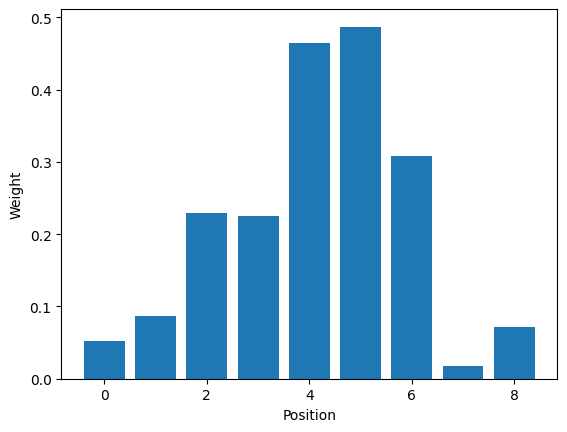

In [63]:
# Plot positional weight profile
plt.bar(np.arange(9),inferred_weights_pan.loc['pan-TCR',])
plt.xlabel('Position')
plt.ylabel('Weight')

Finally, calculate the classification AUC for the peptides of the unseen TCR using pan-TCR weights. This is the baseline performance without performing any AL for the new TCR.

In [64]:
# Get peptide-to-index distance for mutants for the unseen TCR, using pan-TCR parameters
mutant_distance_pan = peptide2index(test_data['index'].tolist(),
                              test_data['peptide'].tolist(),
                              inferred_matrix_pan,
                              inferred_weights_pan.to_numpy())

# Get AUC

# Calculate pairwise AUC for AL-inferred distances
fpr = dict()
tpr = dict()
auc_pan = np.zeros((1,3))
for i in np.arange(0,3): #loop over class-pairs
    fpr[i], tpr[i], _ = roc_curve(test_data.activation[test_data.activation !=i],
                                  -mutant_distance_pan[test_data.activation !=i],
                                  pos_label=max(set(np.arange(0,3)).difference({i})))
    auc_pan[0,i] = auc(fpr[i], tpr[i])

auc_mean = np.nanmean(auc_pan)
print(auc_mean)

0.6554211456959218


# Active Learning for the left out TCR

For the unseen TCR, we pick the first set of 9 peptides using the rule described in the Methods section of our preprint.

In [65]:
# Enter index peptide for the new TCR
index_peptide_candidate_TCR = np.unique(test_data['index'])[0]

# Round 1: Return peptides to sample
al_peptides = return_peptides_to_sample(index_peptide_candidate_TCR, # index peptide
                              inferred_matrix_pan, # AA matrix to find distance
                              inferred_weights_pan.to_numpy() # positional weights
                              )
print(al_peptides)

['LLVPMVATV' 'NHVPMVATV' 'NLMPMVATV' 'NLVEMVATV' 'NLVPLVATV' 'NLVPMLATV'
 'NLVPMVGTV' 'NLVPMVAGV' 'NLVPMVATH']


We see that we are sampling one mutant for each of the 9 possible mutation positions. In an experimental case, one would order these peptides and test them against the new TCR to check for their binding class. Here, we already have a test data file that contains the binding class of these mutants, so we will just use that information to proceed with the AL.

In [66]:
# Build AL training set with 9 sampled peptides
al_train_set = test_data.loc[test_data['peptide'].isin(al_peptides)].copy()

# Include the index peptide in the training set
al_train_index = test_data.loc[test_data['peptide']==index_peptide_candidate_TCR].copy()
al_train_set = pd.concat([al_train_set,al_train_index])

# The rest of the mutants, 171-9=162 in number, constitute the test set
al_test_set = test_data.loc[test_data['peptide'].isin(al_train_set['peptide'])==False].copy()

Now we will perform the first AL round with 10 peptides. For this, we will use the inferred pan-TCR AA matrix to calculate mutant distances, and inferred pan-TCR positional weights to construct the prior for the unseen TCR-specific weights.

In [67]:
# run AL: round 1
w_al,auc_mean = active_learning_cycle(
    al_train_set,al_test_set, #train and test set
    inferred_matrix_pan, #pan-TCR AA matrix
    inferred_weights_pan.to_numpy(), #pan-TCR weights
    steps=20000,
    seed=111)

/usr/local/lib/python3.10/dist-packages/pymc/distributions/transforms.py:58: FutureWarning: univariate_ordered has been deprecated, use ordered instead.
  warnings.warn(f"{name} has been deprecated, use ordered instead.", FutureWarning)


Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


We plot the inferred TCR-specific weights and calculate test AUC after 1 round of active learning.

[[0.         0.02542373 0.8173258  1.         0.57438795 0.68926554
  0.40112994 0.93596987 0.89736347]]


Text(0, 0.5, 'Weight')

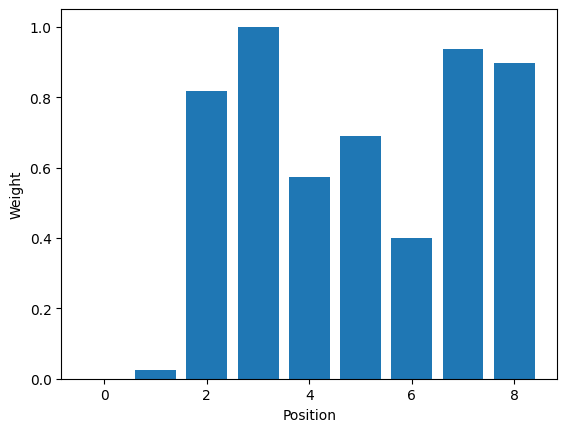

In [68]:
# Plot positional weight profile
print(w_al)
plt.bar(np.arange(9),w_al[0,])
plt.xlabel('Position')
plt.ylabel('Weight')

We see that the positional weight profile have been updated quite a bit from the pan-TCR profile.

In [69]:
# AL results: round 1
print(auc_mean)

0.7098221413289907


The AUC has also improved a lot than the pan-TCR AUC, with just 9 peptides sampled.

Let's do one more round of AL with 9 more peptides sampled in the same way, except now, this time, we use the AL-inferred positional weight profile to inform the sampling. We update the train and test set by taking away 9 sampled peptides from the test set and adding them to the train set. We also specify which peptides are already sampled.

In [70]:
# Round 2: Return peptides to sample
al_peptides = return_peptides_to_sample(index_peptide_candidate_TCR, # index peptide
                              inferred_matrix_pan, # AA matrix to find distance
                              w_al, # AL-inferred positional weights
                              al_train_set['peptide'].tolist() #sampled peptides
                              )
# Get labels for new peptides
al_train_set_addition = test_data.loc[test_data['peptide'].isin(al_peptides)].copy()

# Print new peptides
print(al_train_set_addition['peptide'].to_numpy())

# New train and test set
al_train_set = pd.concat([al_train_set,al_train_set_addition])
al_test_set = test_data.loc[test_data['peptide'].isin(al_train_set['peptide'])==False].copy()

['ALVPMVATV' 'NPVPMVATV' 'NLAPMVATV' 'NLVQMVATV' 'NLVPNVATV' 'NLVPMEATV'
 'NLVPMVRTV' 'NLVPMVASV' 'NLVPMVATM']


Round 2 of AL will be similar as round 1, except that we will use positional weights from round 1 to construct priors for weights to be inferred.

In [71]:
# run AL: round 2
w_al,auc_mean = active_learning_cycle(
    al_train_set,al_test_set,
    inferred_matrix_pan,
    w_al, #AL-inferred weights
    steps=20000,
    seed=111)

/usr/local/lib/python3.10/dist-packages/pymc/distributions/transforms.py:58: FutureWarning: univariate_ordered has been deprecated, use ordered instead.
  warnings.warn(f"{name} has been deprecated, use ordered instead.", FutureWarning)


Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


We can plot the weight profile and AUC after 2 AL rounds.

[[0.00000000e+00 5.23012552e-04 7.20711297e-01 1.00000000e+00
  4.59728033e-01 7.14958159e-01 5.35564854e-01 7.06589958e-01
  6.93514644e-01]]
0.721281045751634


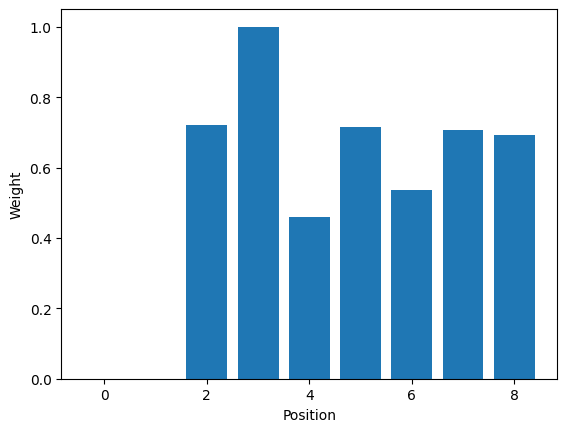

In [72]:
# AL results: round 2
# Plot positional weight profile
print(w_al)
plt.bar(np.arange(9),w_al[0,])
plt.xlabel('Position')
plt.ylabel('Weight')

# Print AUC
print(auc_mean)

The weight profile is changed only slightly from the previous round, indicating we are nearing convergence. The AUC has also improved a bit from the last round.